In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

In [2]:
start = '2010-01-01'
end = '2023-12-31'
stock = 'BRK-B'

data = yf.download(stock, start, end)
data.to_csv('brk-b.csv', index=True)

[*********************100%%**********************]  1 of 1 completed


In [3]:
# Pad NA values
data.fillna( method ='pad', inplace = True)
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,66.000000,66.500000,65.919998,66.220001,66.220001,1575000
2010-01-05,66.389999,66.589996,66.150002,66.540001,66.540001,1310000
2010-01-06,66.500000,66.500000,66.199997,66.199997,66.199997,1760000
2010-01-07,66.199997,66.510002,66.139999,66.459999,66.459999,1505000
2010-01-08,66.480003,66.480003,66.300003,66.440002,66.440002,1500000
...,...,...,...,...,...,...
2023-12-22,356.500000,358.260010,355.410004,356.470001,356.470001,2332200
2023-12-26,356.899994,357.769989,356.079987,356.829987,356.829987,1964400
2023-12-27,355.929993,357.079987,355.500000,356.950012,356.950012,2478500


In [4]:
# Split train test data
data_train = pd.DataFrame(data.Close[0: int(len(data)*0.65)])
data_test = pd.DataFrame(data.Close[int(len(data)*0.65): len(data)])
print('Train: ', data_train.shape[0])
print('Test: ', data_test.shape[0])

Train:  2289
Test:  1233


In [5]:
# Scale training data
scaler = MinMaxScaler(feature_range=(0,1))
data_train_scale = scaler.fit_transform(data_train)
x = []
y = []

for i in range(100, data_train_scale.shape[0]):
    x.append(data_train_scale[i-100:i])
    y.append(data_train_scale[i,0])
x, y = np.array(x), np.array(y)

In [6]:
# Build model
model = Sequential()
model.add(LSTM(units = 50, activation = 'relu', return_sequences = True,
               input_shape = ((x.shape[1], 1))))
model.add(LSTM(units = 50, activation='relu', return_sequences = True))
model.add(LSTM(units = 50, activation = 'relu', return_sequences = False))
model.add(Dense(units = 1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
history=model.fit(x, y, epochs = 10, batch_size = 64, verbose = 1)

Epoch 1/15
35/35 [==============================] - 22s 567ms/step - loss: 0.0650
Epoch 2/15
35/35 [==============================] - 20s 578ms/step - loss: 0.0040
Epoch 3/15
35/35 [==============================] - 20s 574ms/step - loss: 9.9957e-04
Epoch 4/15
35/35 [==============================] - 20s 574ms/step - loss: 7.2175e-04
Epoch 5/15
35/35 [==============================] - 18s 503ms/step - loss: 6.8707e-04
Epoch 6/15
35/35 [==============================] - 19s 554ms/step - loss: 6.5137e-04
Epoch 7/15
35/35 [==============================] - 18s 516ms/step - loss: 6.9433e-04
Epoch 8/15
35/35 [==============================] - 17s 490ms/step - loss: 6.3759e-04
Epoch 9/15
35/35 [==============================] - 18s 527ms/step - loss: 6.9791e-04
Epoch 10/15
35/35 [==============================] - 18s 527ms/step - loss: 6.2651e-04
Epoch 11/15
35/35 [==============================] - 18s 526ms/step - loss: 6.0772e-04
Epoch 12/15
35/35 [==============================] - 18s 526

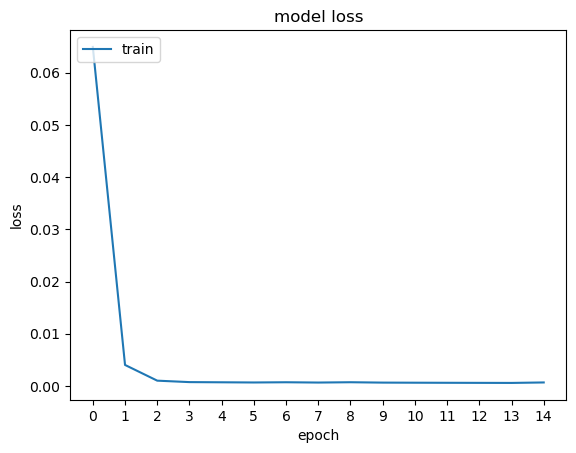

In [8]:
import matplotlib.pyplot as plt
# summarize history for loss
def show_train_history(history):
    plt.plot(history.history['loss'])
    #plt.plot(train_history2.history['val_loss'])
    plt.xticks([i for i in range(0, len(history.history['loss']))])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
show_train_history(history)

In [9]:
# Data for first piece of testing data
past_100_days = data_train.tail(100)
data_test = pd.concat([past_100_days, data_test], ignore_index=True)
data_test_scale  = scaler.fit_transform(data_test)
data_test

,Close
0,214.889999
1,216.369995
2,216.289993
3,218.300003
4,220.949997
...,...
1328,356.470001
1329,356.829987
1330,356.950012
1331,357.570007


In [10]:
x = []
y = []

for i in range(100, data_test_scale.shape[0]):
    x.append(data_test_scale[i-100:i])
    y.append(data_test_scale[i,0])
x, y = np.array(x), np.array(y)
x.shape

(1233, 100, 1)

In [11]:
y_predict = model.predict(x)
print(y_predict.shape)

(1233, 1)


In [12]:
float_y = y.astype(float)
float_y_predict = y_predict.astype(float)
metrics.r2_score(y, y_predict)
print('r2 score', metrics.r2_score(y, y_predict))

r2 score 0.9671288497978927


In [13]:
# 假設y_true是一個NumPy陣列
# 找到y_true陣列中等於零的元素的索引
zero_indices = np.where(y == 0)[0]

if len(zero_indices) > 0:
    print("y_true陣列包含零值，位置在:", zero_indices)
else:
    print("y_true陣列不包含零值")


y_true陣列包含零值，位置在: [282]


In [14]:
# coding=utf-8
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

def smape(y_true, y_pred):
    return 2.0 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true))) * 100

# MSE
print(metrics.mean_squared_error(y, y_predict))
# RMSE
print(np.sqrt(metrics.mean_squared_error(y, y_predict)))
# MAE
print(metrics.mean_absolute_error(y, y_predict))
# MAPE
print(mape(y, y_predict))
# SMAPE
print(smape(y, y_predict))

0.002270590166909365
0.04765071003573153
0.035844848654021155
inf
65.11342310354127


C:\Users\user\AppData\Local\Temp\ipykernel_22296\2182350700.py:3: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_pred - y_true) / y_true)) * 100


In [15]:
y_reshaped = y.reshape(-1, 1)
yi=scaler.inverse_transform(y_reshaped)
y_predict=scaler.inverse_transform(y_predict)

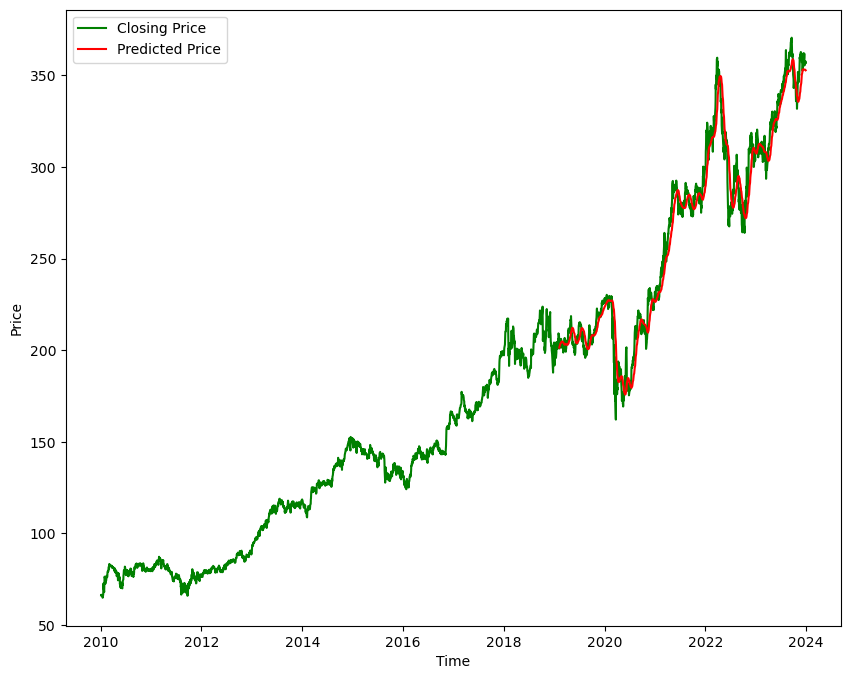

In [16]:
#如果第一行沒有成功就使用註解的程式
test_period = pd.DataFrame(data[int(len(data)*0.65): len(data)])
#test_period = pd.DataFrame(data[int(len(data)*0.65-100): len(data)])
test_period['y_predict'] = y_predict
plt.figure(figsize=(10, 8))
plt.plot(data['Close'], 'g', label='Closing Price')
plt.plot(test_period['y_predict'], 'r', label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()